<img src="resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Workshop SWDB 2024 </h1> 
<h3 align="center">Day 3 2024 - Neuron Morphology</h3> 
<h3 align="center">Notebook 3: EM Synaptic Density</h3> 

In [2]:
%load_ext autoreload

In [3]:
#all imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import cloudvolume
from cloudfiles import CloudFiles
from meshparty import skeleton
import skeleton_plot as skelplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
   
<p>The <b>Electron Microscopy (EM)</b> skeletons include information about the synapses on neurons. However, to understand the strength of this kind of data, we want to consider not only <u>where</u> synapses are, but <u>who</u> they connect to. For this, we need synapse connectivity data. The data you need for this notebook is provided here, but otherwise would be accessed through the <a href=https://allenswdb.github.io/anatomy/microns-em/em-querying-tables.html>Connectome Annotation Versioning Engine</a>. 
        
<p> From the skeletons you have seen so far, we can:
    
<ul>
<li> extract information about synapse number and synapse size
<li> calculate the synapse density as a function of distance from soma
<li> explore the variation of synapse-density across cell types 
</ul>
    
<p> From the cell type connectivity data, we will:
<ul> 
<li> 
</ul>
    
</div>

In [4]:
%autoreload
from utils.skeleton_loading_utils import load_em_skeleton_as_meshwork

In [5]:
skeleton_id = 864691135591041291
sk, conversion_factor = load_em_skeleton_as_meshwork(skeleton_id)

The meshwork skeleton is very handy for masking and performing graph operations, but does not capture some of the other features attached to the skeleton's vertex nodes. For this, we will also use vertex properties from the precomputed skeleton

In [6]:
input_directory = "file://../data/ccf_em_minnie65_v1078" # capsule path
cv_obj = cloudvolume.CloudVolume(input_directory, use_https = True) # Initialize cloud volume
cv_sk = cv_obj.skeleton.get(skeleton_id)

skel_df = pd.DataFrame({'vertex_xyz': [x for x in cv_sk.vertices],
                        'vertex_x': [x[0] for x in cv_sk.vertices],
                        'vertex_y': [x[1] for x in cv_sk.vertices],
                        'vertex_z': [x[2] for x in cv_sk.vertices],
                        'd_path_um': sk.distance_to_root / conversion_factor,
                        'compartment': cv_sk.compartment, 
                        'presyn_counts': cv_sk.presyn_counts, 
                        'presyn_size': cv_sk.presyn_size, 
                        'postsyn_counts': cv_sk.postsyn_counts, 
                        'postsyn_size': cv_sk.postsyn_size,})
skel_df.index.names = ['vertex_index']

skel_df.head(3)

,vertex_xyz,vertex_x,vertex_y,vertex_z,d_path_um,compartment,presyn_counts,presyn_size,postsyn_counts,postsyn_size
vertex_index,,,,,,,,,,
0,"[8028168.5, 1049868.0, 8225758.0]",8028168.5,1049868.000,8225758.0,775.749807,2.0,0.0,0.0,0.0,0.0
1,"[8033898.5, 1053996.1, 8224633.0]",8033898.5,1053996.125,8224633.0,768.555345,2.0,0.0,0.0,0.0,0.0
2,"[8031754.0, 1052311.5, 8224850.0]",8031754.0,1052311.500,8224850.0,771.316866,2.0,0.0,0.0,0.0,0.0


Tip: you may use the utility function `load_em_skeleton_as_df(skeleton_id)` for convenience

In [7]:
from utils.skeleton_loading_utils import load_em_skeleton_as_df

skel_df = load_em_skeleton_as_df(skeleton_id)

### Get euclidean distance to soma, for each vertex

In [8]:
# get the position of the soma
soma_loc = skel_df.loc[skel_df.compartment==1]['vertex_xyz'].values[0]

# calculate euclidean distance at each vertex
skel_df['d_euc_um'] = skel_df.vertex_xyz.apply(lambda x: np.linalg.norm(x - soma_loc) / conversion_factor)

skel_df.tail(3)

,vertex_xyz,vertex_x,vertex_y,vertex_z,d_path_um,compartment,presyn_counts,presyn_size,postsyn_counts,postsyn_size,d_euc_um
vertex_index,,,,,,,,,,,
9151,"[7739545.0, 1135027.2, 9053995.0]",7739545.0,1135027.250,9053995.0,1766.321002,2.0,1.0,7576.0,0.0,0.0,669.498625
9152,"[7739452.5, 1136071.9, 9053438.0]",7739452.5,1136071.875,9053438.0,1767.508456,2.0,0.0,0.0,0.0,0.0,669.565125
9153,"[8091754.0, 858805.0, 8556121.0]",8091754.0,858805.000,8556121.0,0.000000,1.0,0.0,0.0,134.0,542540.0,0.000000


### Visualize euclidean distance and path distance as a histogram

Text(0.5, 1.0, 'Output synapses')

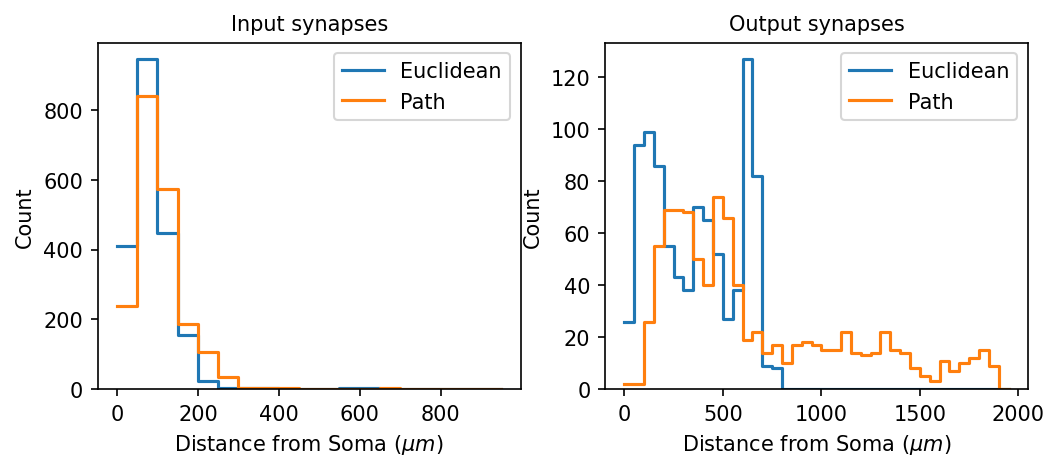

In [9]:
# For bins, use 50 micron bins up to a distance of 1000 microns.
out_syn_skel_df = skel_df.query("presyn_counts>0")
in_syn_skel_df = skel_df.query("postsyn_counts>0")

fig, ax = plt.subplots(1,2, figsize=(8,3), dpi=150)

bins = np.arange(0, 1000, 50)
sns.histplot(
    x='d_euc_um',
    data=in_syn_skel_df,
    bins=bins,
    ax=ax[0],
    stat='count',
    element='step',
    fill=False,
)

sns.histplot(
    x='d_path_um',
    data=in_syn_skel_df,
    bins=bins,
    ax=ax[0],
    stat='count',
    element='step',
    fill=False,
)
ax[0].legend(['Euclidean', 'Path'])
ax[0].set_xlabel('Distance from Soma ($\mu m$)')
ax[0].set_title('Input synapses', fontsize=10)


bins = np.arange(0, 2000, 50)
sns.histplot(
    x='d_euc_um',
    data=out_syn_skel_df,
    bins=bins,
    ax=ax[1],
    stat='count',
    element='step',
    fill=False,
)

sns.histplot(
    x='d_path_um',
    data=out_syn_skel_df,
    bins=bins,
    ax=ax[1],
    stat='count',
    element='step',
    fill=False,
)
ax[1].legend(['Euclidean', 'Path'])
ax[1].set_xlabel('Distance from Soma ($\mu m$)')
ax[1].set_title('Output synapses', fontsize=10)

What does the difference between euclidean distance and path distance tell you?

## Visualize cell with synapses

(7726840.5, 8438740.0, 1497648.0, 675351.375)

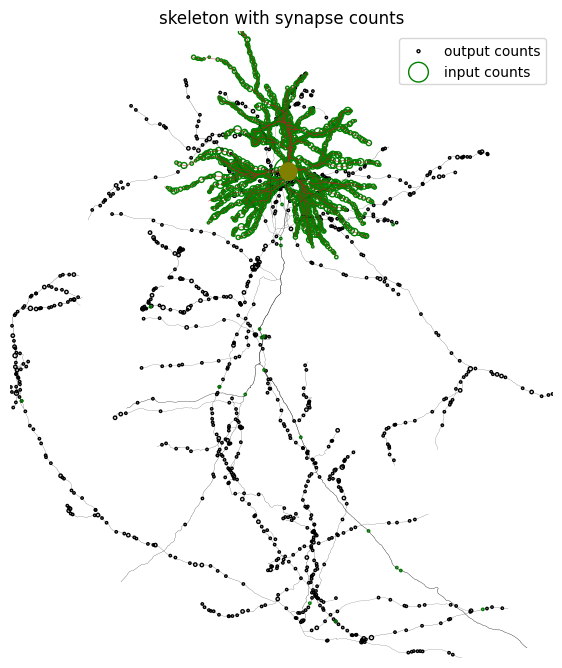

In [10]:
f, ax = plt.subplots(figsize=(7, 10))
skelplot.plot_tools.plot_skel(
    sk,
    title="skeleton with synapse counts",
    line_width=1,
    plot_soma=True,
    soma_size = 150,
    pull_radius=True,
    invert_y=True,
    pull_compartment_colors=True,
    x="x",
    y="y",
    skel_color_map = { 3: "firebrick",4: "salmon",2: "black",1: "olive" },
)

# Plot output synapses
ax.scatter(x=skel_df.vertex_x, y=skel_df.vertex_y,
           s=3*skel_df.presyn_counts, 
           edgecolors ='k', 
           facecolors='none',
           label='output counts')

# # Plot input synapses
ax.scatter(x=skel_df.vertex_x, y=skel_df.vertex_y, 
           s=3*skel_df.postsyn_counts, 
           edgecolors ='g', 
           facecolors='none',
           label='input counts')

ax.legend()

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')

## Next: move from example neuron into population, with segment properties

In [11]:
%autoreload
from utils.skeleton_loading_utils import load_em_segmentprops_to_df


In [12]:
# Load the skeleton segment properties
all_skeletons_df = load_em_segmentprops_to_df()

# Add 'synapse density' as function of total path length
all_skeletons_df['input_density'] = all_skeletons_df.input_synapse_count/all_skeletons_df.dendrite_length_um
all_skeletons_df['output_density'] = all_skeletons_df.output_synapse_count/all_skeletons_df.axon_length_um

all_skeletons_df.head()

,nucleus_id,axon_length_um,dendrite_length_um,input_synapse_count,output_synapse_count,cell_type,brain_area,input_density,output_density
864691136662432990,nuc:258234,28937.876953,5596.291992,14402.0,6649.0,BC,V1,2.573490,0.229768
864691135303514791,nuc:255120,1949.608398,1960.864502,2395.0,444.0,NGC,V1,1.221400,0.227738
864691135976956995,nuc:264843,7577.576172,4549.044434,3828.0,526.0,5P-IT,V1,0.841495,0.069415
864691135867997206,nuc:267165,11305.380859,2961.265381,1957.0,1061.0,5P-IT,V1,0.660866,0.093849
864691136578765076,nuc:269633,8743.079102,3283.718262,2989.0,2130.0,6P-IT,V1,0.910249,0.243621


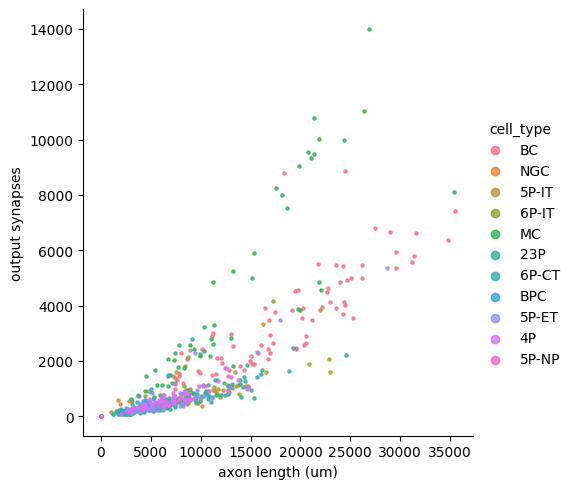

In [13]:
sns.lmplot(x='axon_length_um', y='output_synapse_count', data=all_skeletons_df, fit_reg=False, hue='cell_type', legend=True)

ax = plt.gca()
ax.set_xlabel('axon length (um)')
ax.set_ylabel('output synapses')
for scatters in ax.collections:
    scatters.set_sizes([5])

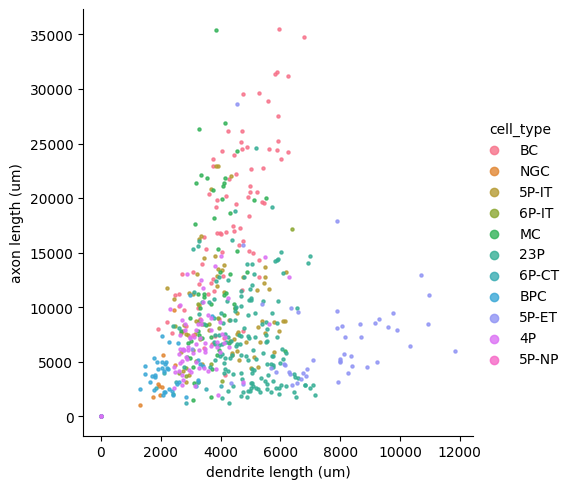

In [14]:
sns.lmplot(x='dendrite_length_um', y='axon_length_um', data=all_skeletons_df, fit_reg=False, hue='cell_type', legend=True)
   
ax = plt.gca()
ax.set_ylabel('axon length (um)')
ax.set_xlabel('dendrite length (um)')
for scatters in ax.collections:
    scatters.set_sizes([5])

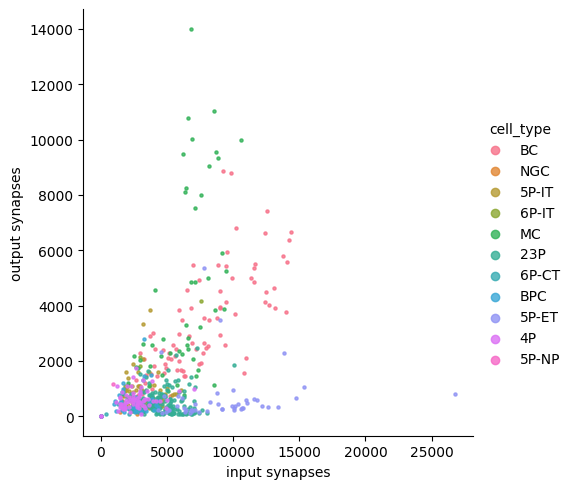

In [15]:
sns.lmplot(x='input_synapse_count', y='output_synapse_count', data=all_skeletons_df, fit_reg=False, hue='cell_type', legend=True)
   
ax = plt.gca()

ax.set_xlabel('input synapses')
ax.set_ylabel('output synapses')
for scatters in ax.collections:
    scatters.set_sizes([5])